In [1]:
import sys

sys.path.append("/media/cyprien/Data/Documents/Github/pytorch-forecasting")

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook

from pytorch_forecasting import Baseline
from utilities import *

from logging import DEBUG, INFO

from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style("whitegrid")
notebook.tqdm().pandas()

pl.seed_everything(42)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


0it [00:00, ?it/s]

Global seed set to 42


42

In [2]:
config = load_config("../config/config.yml")
assert config['model'] == 'rnn', 'Invalid model in file configuration for this script'
config

{'device': 'cpu',
 'seed': False,
 'model': 'rnn',
 'data': {'save': '../data/save/',
  'suppl': '../data/suppl/',
  'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/',
  'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/',
  'financials': 'financials.csv',
  'stock_prices': 'stock_prices.csv',
  'options': 'options.csv',
  'secondary_stock_price': 'secondary_stock_price.csv',
  'trades': 'trades.csv',
  'cosine': 'cosine_df.csv'},
 'rnn': {'sliding_window': {'max_prediction_length': 10,
   'min_prediction_length': 10,
   'max_encoder_length': 150,
   'min_encoder_length': 150,
   'batch_size': 64},
  'train_val_split': 1,
  'related_stock': 0,
  'manual_scale': True,
  'hidden_size': 20,
  'layers': 3,
  'dropout': 0},
 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 10,
   'min_prediction_length': 10,
   'max_encoder_length': 150,
   'min_encoder_length': 150,
   'batch_size': 64},
  'train_val_split': 1,
  

In [3]:
dl = StockPricesLoader(use_previous_files=True, log_level=DEBUG)

DEBUG:data_factory.dataLoader:Export file ../data/save//export_9790f481293c471cb18859c50ad572bf.p
DEBUG:data_factory.dataLoader:Use config {'device': 'cpu', 'seed': False, 'model': 'rnn', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_price.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 150, 'min_encoder_length': 150, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 0, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length

## Baseline Model

### Test set

In [ ]:
actuals = torch.cat([y for x, (y, weight) in tqdm(iter(dl.test_dl))])
predictions = Baseline().predict(dl.test_dl)
print((actuals - predictions).abs().mean().item())

predictions_np = predictions.cpu().detach().numpy()
actuals_np = actuals.cpu().detach().numpy()

In [ ]:
df_test_res = dl.df_test_ppc.copy()

df_test_res['close_true'] = actuals_np[:, 0].flatten()
df_test_res['close_pred'] = predictions_np[:, 0].flatten()
df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res['target_pred'] = (predictions_np[:, 1] - predictions_np[:, 0]) / predictions_np[:, 0]
df_test_res.loc[:, ['Close', 'Close_scaled', 'close_true', 'close_pred', 'Target', 'target_true', 'target_pred']].iloc[:2]

### Results

In [8]:
# Compute unscaled results

actuals_unscaled = actuals_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, 10).copy()
predictions_unscaled = predictions_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, 10).copy()

for i, scaler in enumerate(dl.scalers):
    actuals_unscaled[i] = scaler.inverse_transform(actuals_unscaled[i])
for i, scaler in enumerate(dl.scalers):
    predictions_unscaled[i] = scaler.inverse_transform(predictions_unscaled[i])

actuals_unscaled = actuals_unscaled.reshape(-1, 10)
predictions_unscaled = predictions_unscaled.reshape(-1, 10)

In [31]:
# Add predictions in the dataset

df_test_res = dl.df_test_ppc.copy()

df_test_res['close_true'] = actuals_np[:, 0].flatten()
df_test_res['close_pred'] = predictions_np[:, 0].flatten()

df_test_res['close_true_unscaled'] = actuals_unscaled[:, 0].flatten()
df_test_res['close_pred_unscaled'] = predictions_unscaled[:, 0].flatten()
df_test_res['close_true_1_unscaled'] = actuals_unscaled[:, 9].flatten()
df_test_res['close_pred_1_unscaled'] = predictions_unscaled[:, 9].flatten()

df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res['target_pred'] = (predictions_np[:, 1] - predictions_np[:, 0]) / predictions_np[:, 0]

df_test_res['target_true_unscaled'] = (actuals_unscaled[:, 1] - actuals_unscaled[:, 0]) / actuals_unscaled[:, 0]
df_test_res['target_pred_unscaled'] = (predictions_unscaled[:, 1] - predictions_unscaled[:, 0]) / predictions_unscaled[:, 0]

df_test_res.loc[:, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']].iloc[:4]


/tmp/ipykernel_9904/2992589345.py:13: RuntimeWarning: invalid value encountered in true_divide
  df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
0,2971.0,3065.0,2971.636963,-0.003263,-0.003263,0.000262
1,3065.0,3055.0,3065.041260,0.009820,0.009820,0.000115
2,3055.0,3085.0,3055.348633,0.006483,0.006483,0.000216
3,3085.0,3105.0,3085.555176,-0.006441,0.000000,0.000195


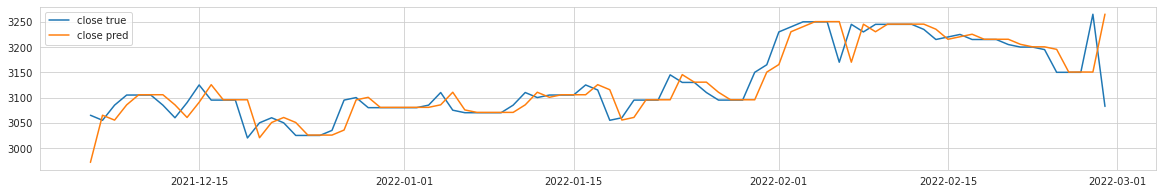

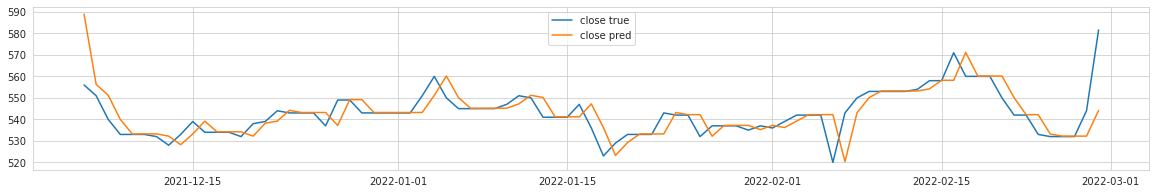

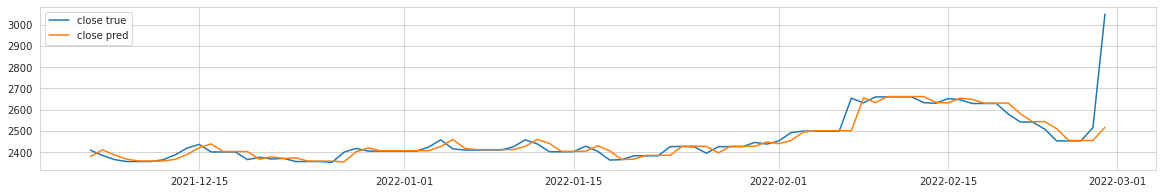

In [32]:
import matplotlib.pyplot as plt

for sc in dl.df_train_ppc.SecuritiesCode.unique()[:3]:
    df = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df.Date, df.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df.Date, df.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

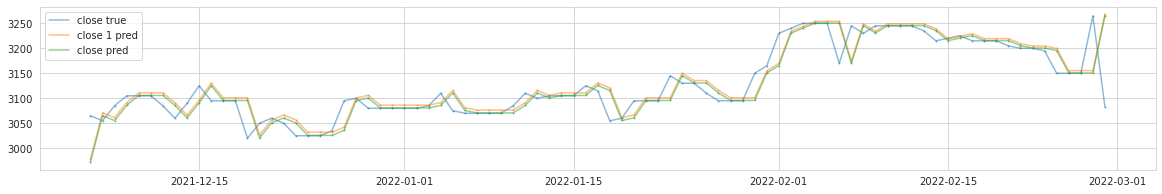

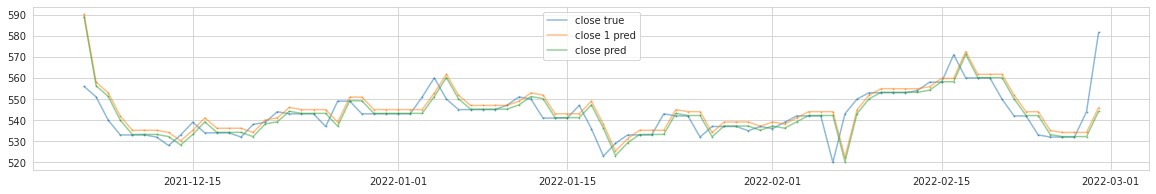

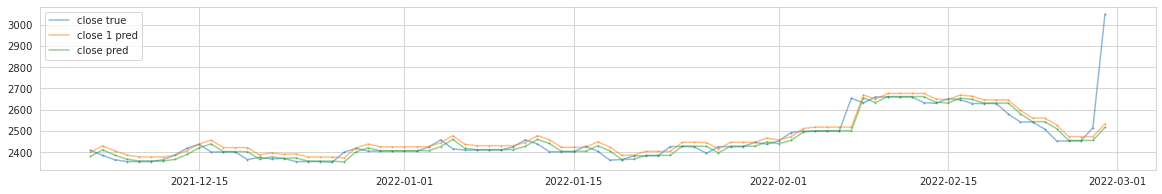

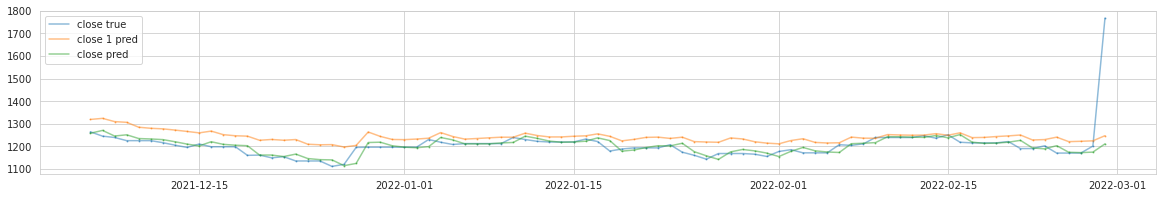

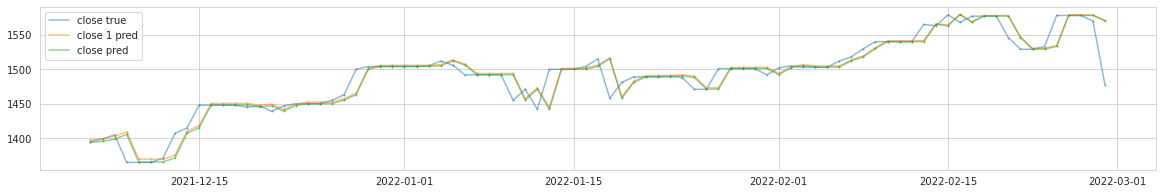

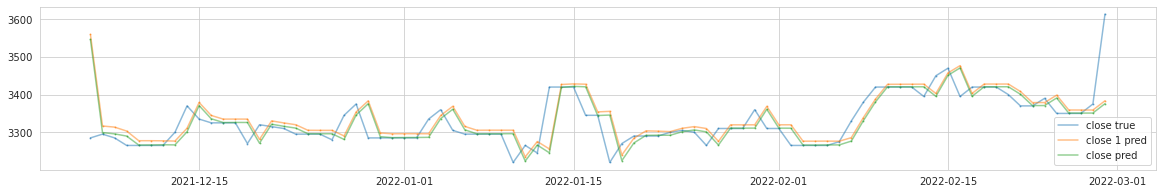

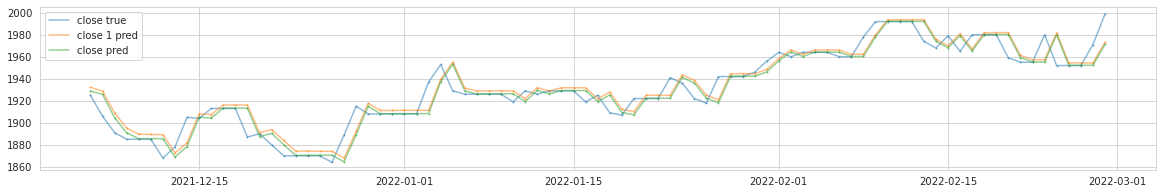

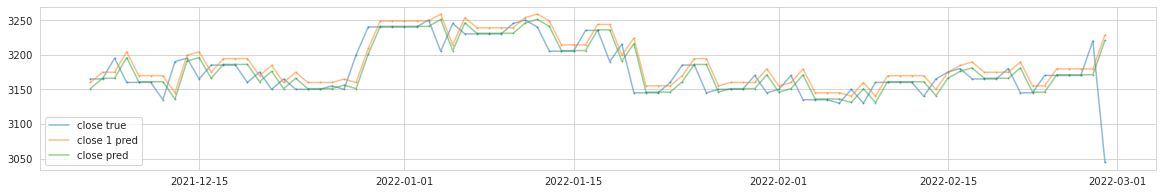

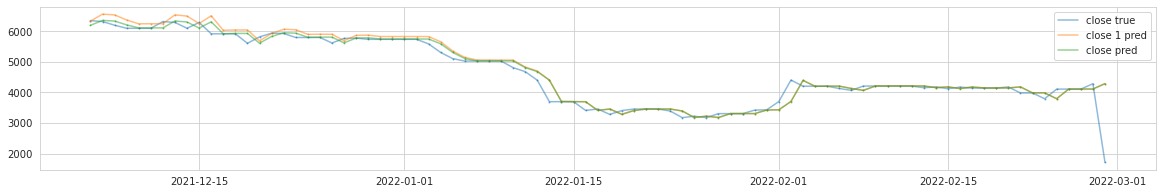

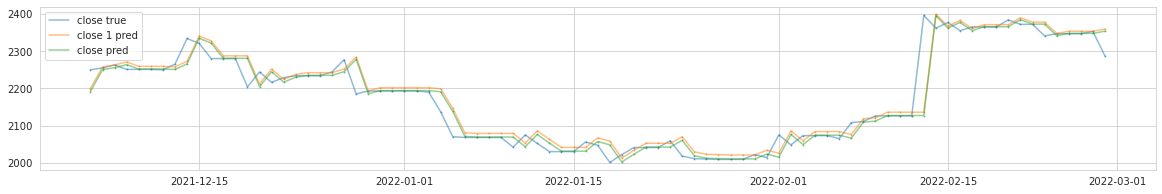

In [44]:
import matplotlib.pyplot as plt

for sc in dl.df_train_ppc.SecuritiesCode.unique()[:10]:
    df = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df.Date, df.close_true_unscaled, label='close true', figure=figure, alpha=.5)
    plt.plot(df.Date, df.close_pred_1_unscaled, label='close 1 pred', figure=figure, alpha=.5)
    plt.plot(df.Date, df.close_pred_unscaled, label='close pred', figure=figure, alpha=.5)

    plt.scatter(df.Date, df.close_true_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df.Date, df.close_pred_1_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df.Date, df.close_pred_unscaled, figure=figure, alpha=.5, s=1)

    plt.legend()
    plt.show()

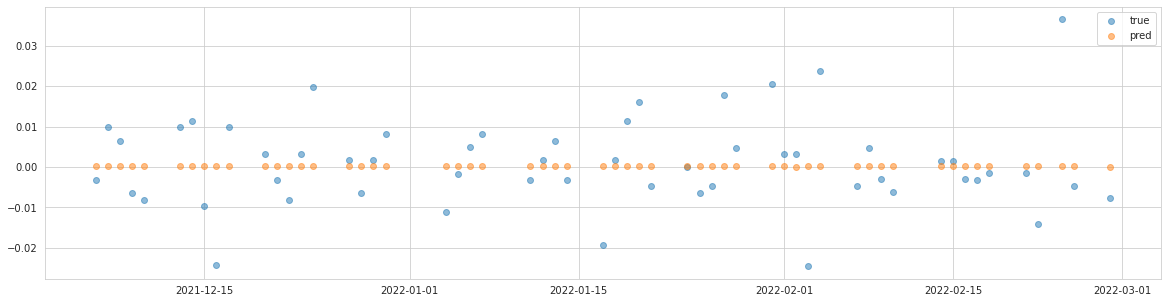

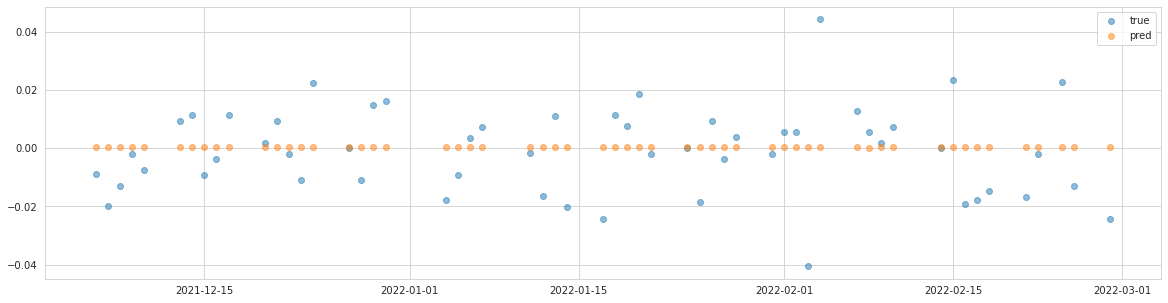

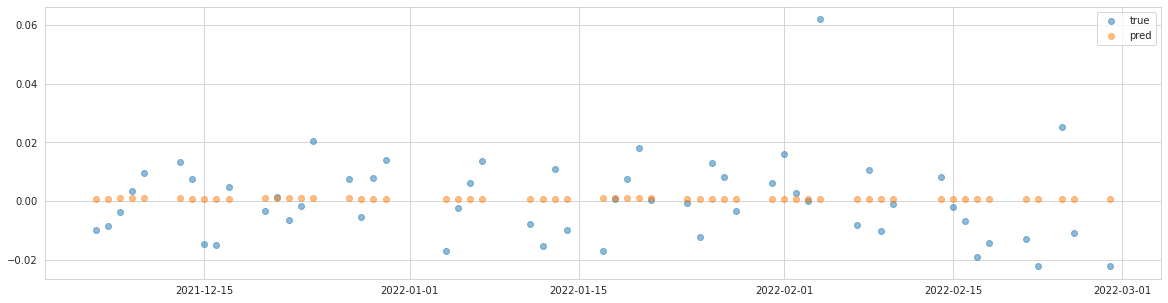

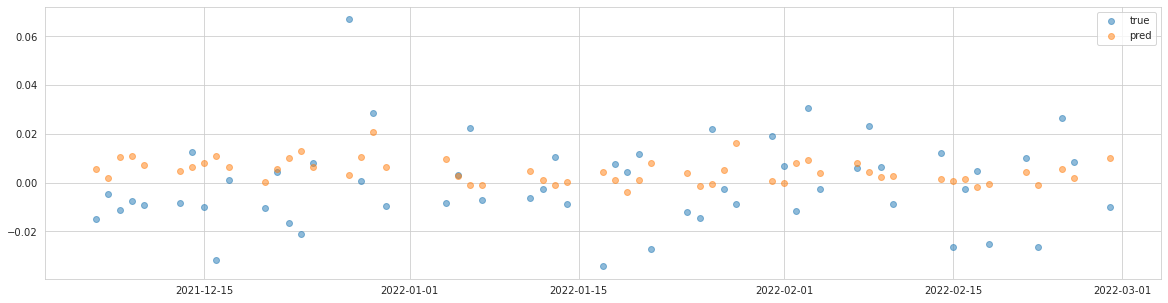

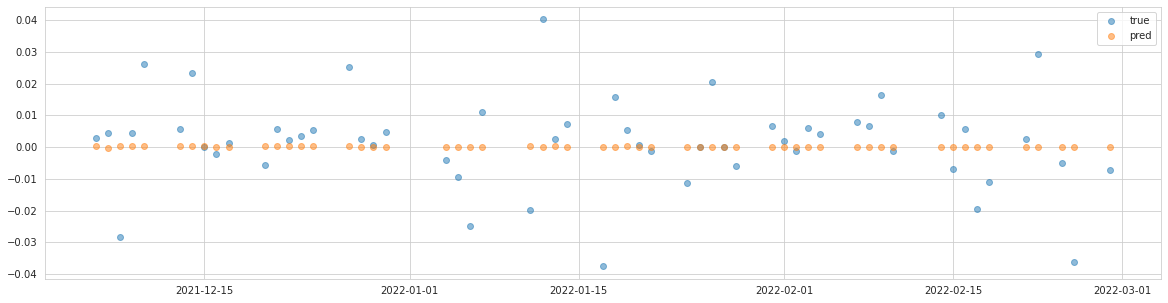

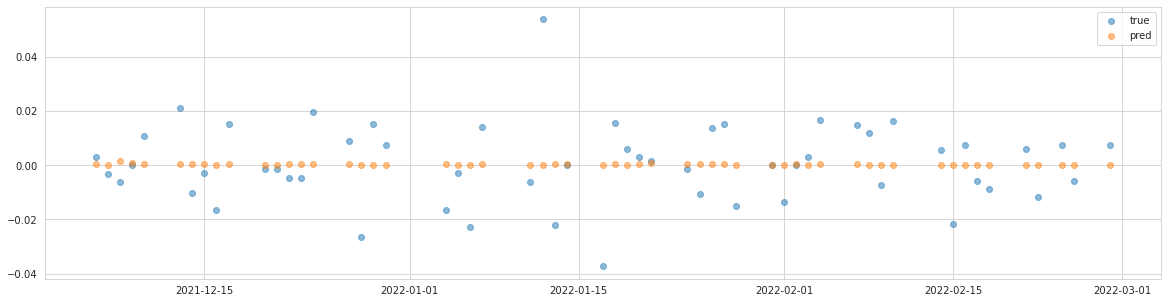

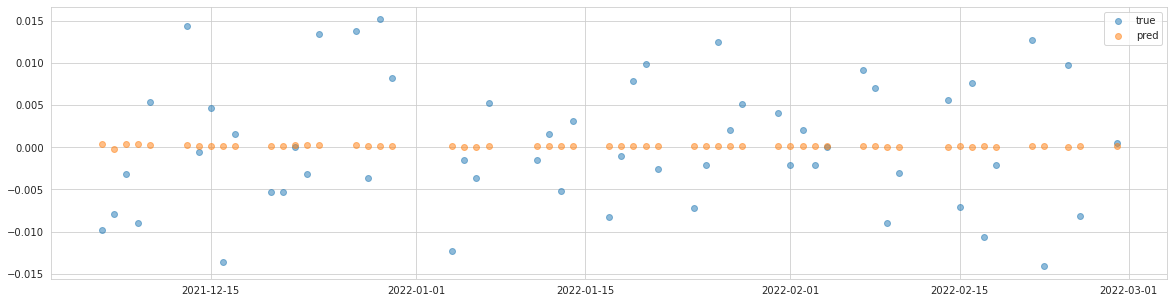

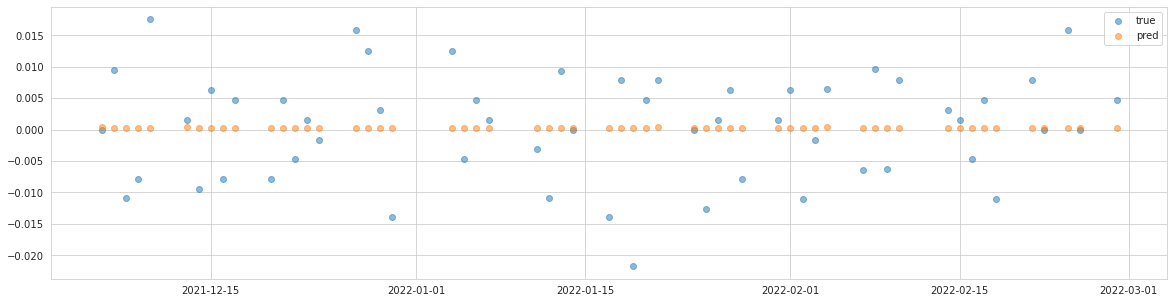

In [11]:
import matplotlib.pyplot as plt

recreated_target_is_valid = df_test_res.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (df_test_res.authentic == True)

for sc in df_test_res.SecuritiesCode.unique()[:8]:
    df = df_test_res[(df_test_res.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df.Date, df.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df.Date, df.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [12]:
from utilities.evaluation import calc_spread_return_sharpe

In [13]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_true_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.9333851997952436

In [14]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.060325485942704225